# 下載vgg_face預訓練模型檔

# 下載範例數據檔

# 程式開始

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from vgg import vggface
from torchvision.models import vgg19
from torchvision.utils import save_image

from dataloader import *
#from model import *
from model_256 import *
from loss import *
from run_utils import *

In [2]:
torch.__version__ 

'1.2.0'

In [14]:
ds = VoxCelebDataset(root='../data/160/', K=8, size=256)
print(len(ds))

160


In [15]:
data_loader = DataLoader(ds, batch_size=8,shuffle=True,num_workers=0,pin_memory=True)

In [7]:
E = Embedder().cuda()
G = Generator().cuda()
D = Discriminator(num_videos=1067).cuda()

In [8]:
E,G,D = load_model(E,G,D, load_model_folder="./model/", postfix="85")

torch.Size([8, 3, 256, 256]) torch.Size([8, 8, 6, 256, 256])


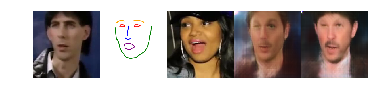

In [16]:
i , source_landmark , target_frame , context = next(iter(data_loader)) 
print( source_landmark.shape, context.shape )
save_n_draw_result(E, G, source_landmark , target_frame , context,
                  save_out_img=False
                   )

In [ ]:
optim_EG = optim.Adam(list(E.parameters())+list(G.parameters()) , lr=5e-5)
optim_D = optim.Adam(D.parameters() , lr=2e-4)

In [ ]:
vgg19 = vgg19(pretrained=True).cuda()
vggface = vggface('vgg_face_dag.pth').cuda()

criterion_EG = LossEG(vggface , vgg19)
criterion_D = LossD()

In [ ]:
epochs = 100
for epoch in range(epochs):
    print(epoch)
    set_W =  True
    
    for i , source_landmark , target_frame , context in data_loader:
        
        source_landmark , target_frame , context = source_landmark.cuda() , target_frame.cuda() , context.cuda()
        
        target_frame_, emb , i = train_step(i , source_landmark , target_frame , context,
                                            set_W=set_W,
                                           )
        
    if epoch%1==0 or epoch+1==epochs:
        i , source_landmark , target_frame , context = next(iter(data_loader)) 
        source_landmark , target_frame , context = source_landmark.cuda() , target_frame.cuda() , context.cuda()
        target_frame_, emb , i = train_step(i , source_landmark , target_frame , context,
                                            print_loss=True
                                           )
        assert len(i) == 8
        save_n_draw_result(E, G, source_landmark , target_frame , context,
                           save_out_img_path='./result/', 
                           save_out_img_fname=f'{str(epoch).zfill(6)}.jpg'
                          )
    if epoch%5==0 or epoch+1==epochs:
        save_model(E, G, D, save_model_folder="./model/", postfix=str(epoch) )
